### **Recurring Efficient Frontier**

In [35]:
# -*- coding: utf-8 -*-
"""
Created on Tue June 29 9:12:23 2021

@author: Bradley

Project for Displaying Efficient Frontier
"""

'\nCreated on Tue June 29 9:12:23 2021\n\n@author: Bradley\n\nProject of Displaying Efficient Frontier\n'

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tushare as ts
from datetime import datetime
import scipy
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' 
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')  

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [149]:
def get_data(code: np.str, start_date:np.str, end_date:np.str) -> pd.DataFrame:
    ts.set_token('0d86b9a1aa5a9ba78b7e3a2feba63242abaeae62c777f5742f6cf698')
    pro = ts.pro_api() 
    data = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')
    code = data[data['symbol']==code]['ts_code'].values.tolist()[0] #tushare的pro_bar参数里code需要有后缀

    df = ts.pro_bar(api=pro, ts_code=code, adj='qfq', start_date=start_date, end_date=end_date) 
    df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d') 
    df = df.set_index('trade_date', drop=False) 
    df.index.name = 'Date'
    df = df.sort_index()
    df['log_return'] = np.log(df['close']/df['pre_close'])
    df['log_return'] = df['log_return'].shift(-2) #这步平移不是必须的
    df.dropna(inplace=True)
    return df

def ret_weight(df:pd.DataFrame, weight:np.array): 
    mean = df.mean()*252
    return sum(weight * mean)

def std_weight(df:pd.DataFrame, weight:np.array): 
    cov = df.cov()*252
    var = np.dot(weight, cov)
    var = np.dot(var, weight.T)
    std = np.sqrt(var)
    return std

def construct_portfolio(code_list, start_date, end_date) -> pd.DataFrame:
    nums = []
    for code in code_list:
        df = get_data(code, start_date, end_date)
        log_ret = df[['log_return']]
        log_ret = log_ret.rename(columns={'log_return':'log_return_%s'%code})
        nums.append(log_ret)
    ret_combined = pd.concat(nums, axis=1, join='inner')
    return ret_combined

def feasible_region_drawing(df:pd.DataFrame, N):
    stds = []
    rets = []
    for _ in range(10000):
        weight = np.random.rand(N)
        weight /= sum(weight)
        ret = ret_weight(df,weight)
        std = std_weight(df,weight)
        rets.append(ret)
        stds.append(std)
    plt.scatter(stds, rets, color='#660066') 

def calculate_opt_weight(given_ret, df:pd.DataFrame, N):
    x0 = np.repeat(1/N, N)
    bounds = tuple((0,1) for _ in range(N))
    constraints = [{'type':'eq','fun':lambda x: sum(x)-1}, {'type':'eq','fun': lambda x: ret_weight(df,x)-given_ret}]
    outcome = scipy.optimize.minimize(lambda x: std_weight(df,x),x0=x0, constraints=constraints,bounds=bounds)
    return outcome.fun,outcome.x

def efficient_frontier_drawing(df, N):
    given_ret = np.arange(-0.02, 0.08, .0005) 
    calculated_std = []
    for i in given_ret:
        calculated_std.append(calculate_opt_weight(i, df, N)[0])
    plt.scatter(calculated_std, given_ret, color='#660066',alpha=0.7, linewidths=0.5, edgecolors='#680808')
    #plt.plot(calculated_std, given_ret, color='#680808',alpha=0.7, linewidth=2.5, linestyle='dashdot')



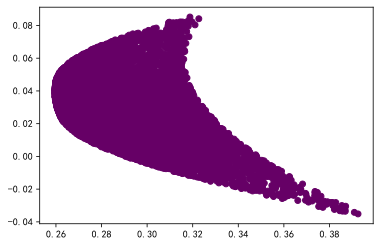

In [150]:
code_list = ['000001','600000','600030']
start_date = '20150101'
end_date = '20191231'
portfolio = construct_portfolio(code_list, start_date, end_date)
feasible_region_drawing(portfolio,len(code_list))

In [148]:
code_list = ['000001','600000','600030']
start_date = '20150101'
end_date = '20191231'
portfolio = construct_portfolio(code_list, start_date, end_date)
calculate_opt_weight(0.16,portfolio,len(code_list))

(0.3246035507284691, array([1.00000000e+00, 2.16745681e-12, 4.80136434e-18]))

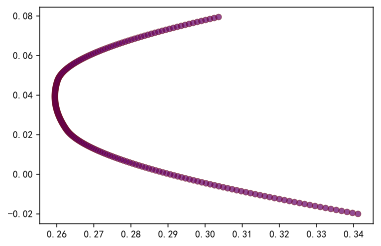

In [151]:
code_list = ['000001','600000','600030']
start_date = '20150101'
end_date = '20191231'
portfolio = construct_portfolio(code_list, start_date, end_date)
efficient_frontier_drawing(portfolio,len(code_list))

In [158]:
start_date = '20150101'
end_date = '20191231'
code = '000538'
ts.set_token('0d86b9a1aa5a9ba78b7e3a2feba63242abaeae62c777f5742f6cf698')
pro = ts.pro_api() 
data = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')
code = data[data['symbol']==code]['ts_code'].values.tolist()[0] #tushare的pro_bar参数里code需要有后缀

df = ts.pro_bar(api=pro, ts_code=code, adj='qfq', start_date=start_date, end_date=end_date) 
df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d') 
df = df.set_index('trade_date', drop=False) 
df.index.name = 'Date'
df = df.sort_index()
df['log_return'] = np.log(df['close']/df['pre_close'])
df['log_return'] = df['log_return'].shift(-2) #这步平移不是必须的
df.dropna(inplace=True)
df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,log_return
Date,,,,,,,,,,,,
2015-01-05,000538.SZ,2015-01-05,59.1232,61.7719,58.5803,60.7891,59.1044,1.6847,2.8504,198489.54,1.278907e+06,-0.007915
2015-01-06,000538.SZ,2015-01-06,60.7423,65.9368,59.9000,62.9231,60.7891,2.1340,3.5105,232618.20,1.566887e+06,0.000000
2015-01-07,000538.SZ,2015-01-07,62.6610,62.8950,61.4256,62.4270,62.9231,-0.4961,-0.7884,113365.45,7.515732e+05,-0.028900
2015-01-08,000538.SZ,2015-01-08,62.3147,65.1319,62.1182,62.4270,62.4270,0.0000,0.0000,115356.32,7.787680e+05,0.004619
2015-01-09,000538.SZ,2015-01-09,62.4270,63.0541,60.6487,60.6487,62.4270,-1.7783,-2.8486,132380.17,8.710561e+05,-0.001998
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,000538.SZ,2019-12-23,86.3900,87.5900,85.6000,86.4600,86.4000,0.0600,0.0694,33207.39,2.885265e+05,0.006686
2019-12-24,000538.SZ,2019-12-24,86.4000,88.5000,86.3000,87.9500,86.4600,1.4900,1.7233,39421.09,3.462044e+05,-0.006231
2019-12-25,000538.SZ,2019-12-25,87.9000,89.6200,87.7600,88.5400,87.9500,0.5900,0.6708,40607.19,3.610290e+05,-0.003757


In [159]:
code_list = ['000001','600000','600030','600519','000672','601857','002230','000538']
start_date = '20150101'
end_date = '20191231'
portfolio = construct_portfolio(code_list, start_date, end_date)
portfolio

,log_return_000001,log_return_600000,log_return_600030,log_return_600519,log_return_000672,log_return_601857,log_return_002230,log_return_000538
Date,,,,,,,,
2015-01-05,-0.019189,-0.020045,0.040647,-0.025029,-0.007947,0.058160,-0.018936,-0.007915
2015-01-06,-0.034174,-0.036056,-0.025209,-0.006135,0.004546,-0.014634,0.000000,0.000000
2015-01-07,0.007989,0.011732,-0.008261,-0.007590,0.016870,-0.011537,-0.003687,-0.028900
2015-01-08,-0.020775,-0.013706,-0.041766,-0.020598,-0.052645,-0.037989,0.029453,0.004619
2015-01-09,-0.006104,-0.002631,-0.041404,-0.008349,-0.013017,0.001712,0.027911,-0.001998
...,...,...,...,...,...,...,...,...
2019-12-23,-0.006116,-0.003263,-0.002159,-0.012535,0.007076,-0.001747,0.009739,0.006686
2019-12-24,0.010375,0.004077,0.026452,0.001234,0.011682,0.001747,0.042829,-0.006231
2019-12-25,0.009668,0.002438,-0.017842,0.024282,-0.018758,0.008688,-0.035513,-0.003757


In [165]:
a = pd.DataFrame({'a':[1,2,3,4],'b':[5,6,7,8]})
np.linspace(np.min(np.mean(a,axis=0)),np.max(np.mean(a,axis=0)),num=10)

array([2.5       , 2.94444444, 3.38888889, 3.83333333, 4.27777778,
       4.72222222, 5.16666667, 5.61111111, 6.05555556, 6.5       ])